# LangGraph

LangGraph is a framework that allows you to define execution flows. It is designed for building agentic systems.

In [23]:
from time import sleep

import typing
from typing import TypedDict, Literal

import langgraph
import langchain_core
import langgraph.prebuilt
from langgraph.types import Command
from langgraph.graph import END, START, StateGraph, MessagesState

from langchain_ollama import ChatOllama

## State

The **state** is the object that moves through the entire graph. It provides the input information to the nodes and passes the information from the current node to the next one.

The schema of the `State` must be provided when defining of the `langgraph.graph.StateGraph`. Supported ways to define a schema include: `typing.TypedDict`, `dataclasses.dataclass`, or `pydantic.BaseModel`.

Check more cases in the [State](langgraph/state.ipynb)

---

Consider a case in which the state is defined as a `dataclass`. The following cell creates a graph that processes a `State` dataclass instance and increments the `inp` attribute. 

In [13]:
from dataclasses import dataclass


@dataclass
class State:
    inp: int


def my_node(state: State):
    print(state)
    state.inp += 1
    return state


builder = StateGraph(State)
builder.add_node("my", my_node)

builder.add_edge(START, "my")
builder.add_edge("my", END)

graph = builder.compile()

The following cell invokes the graph for `State(inp=4)`.

In [15]:
graph.invoke(State(inp=4))

State(inp=4)


{'inp': 5}

## Parallel execution

If a node has multiple outgoing edges, the flows defined by those edges will execute in parallel.

---

The following cell defines and displays this type of graph. The nodes of the graph display information about the start and end of exection, and block the flow for a while.

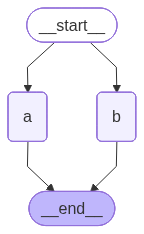

In [11]:
class State(TypedDict):
    pass


builder = StateGraph(State)


def node_a(state: State):
    print("executing a")
    sleep(10)
    print("finishing a")


def node_b(state: State):
    print("executing b")
    sleep(10)
    print("execution b")


builder.add_node("a", node_a)
builder.add_node("b", node_b)

builder.add_edge(START, "a")
builder.add_edge(START, "b")
graph = builder.compile()
graph

The project's invocation is represented in the following cell:

In [12]:
graph.invoke(State())

executing a
executing b
finishing a
execution b


It follows from the result that flows was executed in parallel.

## Reducing

If two graph flows join at the same node and both return a value, there will be a conflict. You must specify a strategy for merging the outputs using a **reducer function**.

THe **reducer function** can be defined as metatdata of the `typing.Annotated` for the specific attribute. This function will be applied if the outputs from those nodes need to be processed in some way. The most common way is to use the `operator.add` function, which is equivalent to simply apply the `+` operator.

Check more in [Reducing](langgraph/reducing.ipynb) page.

---

The following cell shows the definition of the state that applies `operator.add` when there are two outputs in a node.

In [5]:
import operator
from typing import Annotated


class State(TypedDict):
    out: Annotated[str, operator.add]

The next code creates a graph with two parallel nodes, each attempt to update the `out` attribute of the state.

In [6]:
def node_a(state: State) -> State:
    return State(out="A output")


def node_b(state: State) -> State:
    return State(out="B output")


builder = StateGraph(State)

builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_edge(START, "a")
builder.add_edge(START, "b")

graph = builder.compile()
graph.invoke(State(out="value"))

{'out': 'valueA outputB output'}

As a result, the outputs of the different nodes were simply concatenated.

## Conditional edges

Conditional edges allow you to define a graph that will go one way or another depending on the conditions.

You can define the conditional node using:

- Adding the node that returns `langgraph.types.Command` with `goto` specifying the name of the next node.
- Adding the edge with `add_conditional_edge` method of the graph builder.

Find out more in the [Conditional edges](langgraph/conditionla_edges.ipynb).

---

The following cell defines the conditional node that directs the execution to either the `END` or `"a"` node, depending on the corresponding value of the `state["goto"]`.

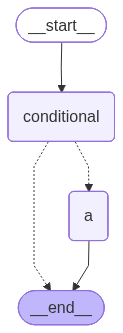

In [ ]:
class State(TypedDict):
    goto: Literal["a", "__end__"]


def node_a(state: State) -> State:
    print("a node is invoked")
    return state


def conditional_node(state: State) -> Command[Literal["a", "__end__"]]:
    return Command(update=state, goto=state["goto"])


graph = (
    StateGraph(State)
    .add_node("conditional", conditional_node)
    .add_node("a", node_a)

    .add_edge(START, "conditional")
    .add_edge("a", END)
    .compile()
)
graph

The following cell invokes the graph with to be executed with the `"a"` node.

In [28]:
_ = graph.invoke(State(goto="a"))

a node is invoked


And alternatively routing directly to the `__end__`.

In [30]:
_ = graph.invoke(State(goto="__end__"))

We always receive messages from random nodes, but always only two of them.

### Tools condition

The `langgraph.prebuilt.tools_condition` function is designed for use in conditional edges that determine wheather to went to go to the `tools` node or to end the execution. 

---

The following cell defines the conditional edge useing the `langgraph.prebuilt.tools_condition` as a decision function.

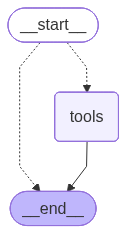

In [30]:
def tool_node(state: MessagesState):
    print("tool node is invoked")


def regular_node(state: MessagesState):
    print("reuglar node is invoked")


graph = (
    StateGraph(MessagesState)
    .add_node("tools", tool_node)
    .add_conditional_edges(
        START,
        langgraph.prebuilt.tools_condition,
    )
    .compile()
)
graph

As a resutl, the `__start__` node refers either to the `tools` node or to the `__end__` node. 

Consider how the output of this funciton depends on the input. The following cell passes the regular message without any tools calls to the `langgraph.prebuilt.tools_condition`.

In [7]:
langgraph.prebuilt.tools_condition(
    MessagesState(messages=[
        langchain_core.messages.AIMessage(content="Retular output.")
    ])
)

'__end__'

The result condition directs the flow to the `__end__` of the graph.

The crucial case here is the case when the message contains the root call.

In [29]:
langgraph.prebuilt.tools_condition(
    MessagesState(messages=[
        langchain_core.messages.AIMessage(
            content="",
            tool_calls=[{
                "id": "call_1",
                "name": "search",
                "args": {"query": "LangGraph conditions"}
            }]
        )
    ])
)

'tools'

The function returns the `tools` node to be executed next.

## Memory

You can save the state between the graph infocations. During graph compilation, you must pass a `checkpointer` object. This object will keep the output of the previous invocation bounded to **thread**. The thread is specified by the `configurable.thread_id` field of the `configuration` argument. 

---

The following cell builds and compiles the graph. Note that the checkpointer passes an `InMemorySaver` instance, which stores the information about the outputs of the last invocation in memory. Each time the graph is invoked, a random number is added to the input.

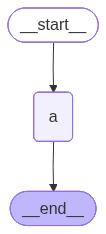

In [103]:
import operator
from random import randint
from typing import Annotated
from langgraph.checkpoint.memory import InMemorySaver

in_memory_saver = InMemorySaver()


class State(TypedDict):
    value: Annotated[list[int], operator.add]


def node_a(state: State) -> State:
    return State(value=[randint(0, 10)])


graph = (
    StateGraph(State)
    .add_node("a", node_a)

    .add_edge(START, "a")
    .add_edge("a", END)

    .compile(checkpointer=in_memory_saver)
)
graph

Invoking such a graph requires specifying the thread because memory is bounded by the thread.

In [104]:
graph.invoke(
    State(value=[]),
    {"configurable": {"thread_id": 1}}
)

{'value': [9]}

The second invocation with the same specified thread contains the output of the previous invocation, plus the new generated number:

In [105]:
graph.invoke(
    State(value=[]),
    {"configurable": {"thread_id": 1}}
)

{'value': [9, 2]}

The invocation in the other thread yelds a new number:

In [106]:
graph.invoke(
    State(value=[]),
    {"configurable": {"thread_id": 2}}
)

{'value': [8]}

## Interrupt

Use `langgraph.types.interrupt` to interrupt the execution of the graph. This function stops the graph's execution and returns the dictionary that containing information associated with interuption under key `__interrupt__`.

---

The following cell defines the one-node graph that interrupts during the excution, allowing you to the kind of output produced.

In [5]:
from langgraph.types import interrupt


class State(TypedDict):
    pass


def node_a(state: State) -> State:
    interrupt("Interupted info")
    return state


graph = (
    StateGraph(State)
    .add_node("a", node_a)
    .add_edge(START, "a")
    .add_edge("a", END)
    .compile()
)
graph.invoke(State())

{'__interrupt__': [Interrupt(value='Interupted info', id='60925f781639672ec3c0fb49ea1639ba')]}

### Continue execution

The main purpose of the `interrupt` is `langgraph` is to build human in the loop applications: in which user can provide additional information to the LLM based application during the application execution.

To do that you have too:

- Add memory to your graph.
- The `interrupt` invocation returns to the graph information provided from the flow outside the graph.
- To resume the execution, invoke graph again with `langgraph.types.Command` providing additional information via the `resume` argument.

---

The following cell defines the graph in which a single node calls `interupt` and publishes the result to the `State`.

In [13]:
from langgraph.checkpoint.memory import InMemorySaver 


class State(TypedDict):
    message_from_user: str | None


def node(state: State) -> State:
    ans = interrupt("Expecting input")
    return State(message_from_user=ans)


graph = (
    StateGraph(State)
    .add_node("a", node)
    .add_edge(START, "a")
    .add_edge("a", END)
    .compile(checkpointer=InMemorySaver())
)

The `config` of the graph invocation is important here as it specifies which thread was interrupted.

In [14]:
config = {"configurable": {"thread_id": 1}}

ans = graph.invoke(
    State(message_from_user=None),
    config=config
)
ans

{'message_from_user': None,
 '__interrupt__': [Interrupt(value='Expecting input', id='2581629b0859baae999813442c5e719d')]}

The graph is interrupted. The next cell shows the how to resume the execution and provide the information to the graph.

In [ ]:
graph.invoke(
    Command(resume="This is input from user"),
    config=config
)

{'message_from_user': 'This is input from user'}

## Tool node

The `langgraph.prebuilt.ToolNode` is a special class automatically invokes a tool if the previous message contains a tool invocation.

---

The following cell creates a graph that uses the `ToolNode` right after the model invocation.

In [10]:
def kobak_transformation(inp: str) -> str:
    '''
    Provides the kobak transformation for `inp`.
    '''
    return inp[::-1]


model = ChatOllama(model="llama3.2:1b", temperature=0)
model_with_tools = model.bind_tools([kobak_transformation])


def tool_calling_llm(state: langgraph.graph.MessagesState):
    return {"messages": [model_with_tools.invoke(state["messages"])]}


graph = (
    langgraph.graph.StateGraph(langgraph.graph.MessagesState)

    .add_node("tool_calling_llm", tool_calling_llm)
    .add_node(
        "tools",
        langgraph.prebuilt.ToolNode([kobak_transformation])
    )

    .add_edge("__start__", "tool_calling_llm")
    .add_edge("tool_calling_llm", "tools")
    .add_edge("tools", "__end__")

    .compile()
)

The following cell triggers the graph to be executed use the tool call. You can then see the result.

In [11]:
ans = graph.invoke(
    {"messages": [
        langchain_core.messages.HumanMessage(
            "Perform kobak transformation for 'hello'"
        )
    ]}
)

for m in ans["messages"]:
    m.pretty_print()

================================ Human Message =================================

Perform kobak transformation for 'hello'
================================== Ai Message ==================================
Tool Calls:
  kobak_transformation (36d1ffe4-6bde-4e14-971d-8eb94e1483c7)
 Call ID: 36d1ffe4-6bde-4e14-971d-8eb94e1483c7
  Args:
    inp: hello
================================= Tool Message =================================
Name: kobak_transformation

olleh


## Studio

The studio is a graphical IDE that allows you to monitor the execution of your graphs.

To use studio you have to setup the [langgraph application](https://docs.langchain.com/langsmith/application-structure#python) and run there `langgraph dev` command.

---

The following cell setsup the simplest possible langgraph application.

In [11]:
!rm -rf /tmp/studio && mkdir /tmp/studio

In [6]:
%%writefile /tmp/studio/my_graph.py
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    message: str
    value: int

def node(state: State):
    return state

state_graph = (
    StateGraph(State)
    .add_node("a", node)
    .add_edge(START, "a")
    .add_edge("a", END)
)

Overwriting /tmp/studio/my_graph.py


By settings `LANGSMITH_TRACING=false` environment variable you can turn off the tracking with langsmith.

In [9]:
%%writefile /tmp/studio/.env
LANGSMITH_TRACING=false

Overwriting /tmp/studio/.env


The `langgraph.json` determines the langgraph application.

In [10]:
%%writefile /tmp/studio/langgraph.json
{
    "dependencies": [
        "langgraph"
    ],
    "graphs": {
        "my_agent": "./my_graph.py:state_graph"
    },
    "env": ".env"
}

Overwriting /tmp/studio/langgraph.json


Run the langgraph Studio with commands:

```bash
cd /tmp/studio
langgraph dev
```

In the `http://localhost:2024` you will be able to see the UI of the application.